# ML7 Практика

Наша практика будет основана на соревновании Kaggle: Predicting a Biological Response (Прогнозирование биологического ответа).

Необходимо предсказать биологический ответ молекул (столбец '`Activity`') по их химическому составу (столбцы `D1-D1776`).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец `Activity` содержит экспериментальные данные, описывающие фактический биологический ответ `[0, 1]`; 
Остальные столбцы `D1-D1776` представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать `F1-score`.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (`GridSeachCV`, `RandomizedSearchCV`, `Hyperopt`, `Optuna`) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [197]:
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn import ensemble
from sklearn import model_selection
from sklearn import metrics

import hyperopt
from hyperopt import hp, tpe, space_eval, fmin
import optuna

import seaborn as sns

Загружаем данные

In [4]:
data = pd.read_csv('data/_train_sem09__1_.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Проверяем наличие пропусков

In [8]:
data.isna().sum().sum()

0

Смотрим на сбалансированность классов

<Axes: xlabel='Activity', ylabel='count'>

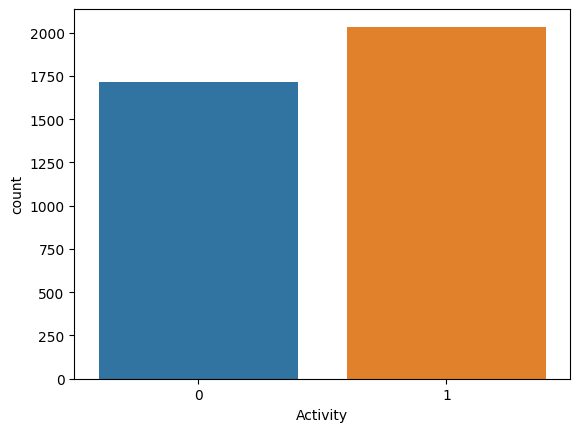

In [10]:
sns.countplot(data=data, x='Activity')

**Вывод**: классы довольно сбалансированны.

Создаём матрицу наблюдений и вектор ответов

In [13]:
X = data.drop(columns='Activity')
y = data['Activity']

Разделяем выборку на тренировочную и тестовую. Хоть выборка и более менее сбалансирована, всё равно проведём стратифицированное разбиение для чистоты эксперименты.

In [18]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('TRAIN shapes: ', X_train.shape, y_train.shape)
print('TEST shapes: ', X_test.shape, y_test.shape)

TRAIN shapes:  (3000, 1776) (3000,)
TEST shapes:  (751, 1776) (751,)


## <center> **GridSearchCV**

### LogisticRegression

In [26]:
param_grid_lr = [
    {'penalty': ['l2', 'None'],
     'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
    
    {'penalty': ['l1', 'l2'],
     'solver': ['liblinear'],
     'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
    
    {'penalty': ['elasticnet', 'l1', 'l2', 'None'],
     'solver': ['saga'],
     'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

grid_search_lr = model_selection.GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42,
        max_iter=1000
    ),
    param_grid=param_grid_lr,
    cv=5,
    n_jobs=-1
)

%time grid_search.fit(X_train, y_train)
y_test_gs_pred = grid_search_lr.predict(X_test)
print(f'F1 на тестовом наборе: {metrics.f1_score(y_true=y_test, y_pred=y_test_gs_pred):.2f}')
print(f'лучшие значения гиперпараметров: {grid_search_lr.best_params_}')
print(f'лучшая модель:\n{grid_search_lr.best_estimator_}')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

CPU times: user 1.18 s, sys: 290 ms, total: 1.47 s
Wall time: 4min 31s
F1 на тестовом наборе: 0.78
лучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}
лучшая модель:
LogisticRegression(C=0.3, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')


### RandomForest

In [29]:
param_grid_rf = {
    'n_estimators': [5, 10, 30, 50, 70, 100, 120, 140, 160, 180, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [2, 3, 5, 8, 13, 21],
    'min_samples_leaf': [2, 3, 5, 8, 13, 21, 34]
}

grid_search_rf = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    n_jobs=-1
)

%time grid_search_rf.fit(X_train, y_train)
y_test_gs_pred = grid_search_rf.predict(X_test)
print(f'F1 на тестовом наборе: {metrics.f1_score(y_true=y_test, y_pred=y_test_gs_pred):.2f}')
print(f'лучшие значения гиперпараметров: {grid_search_rf.best_params_}')
print(f'лучшая модель:\n{grid_search_rf.best_estimator_}')

CPU times: user 16.2 s, sys: 2.75 s, total: 19 s
Wall time: 9min 58s
F1 на тестовом наборе: 0.80
лучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 21, 'min_samples_leaf': 2, 'n_estimators': 200}
лучшая модель:
RandomForestClassifier(max_depth=21, min_samples_leaf=2, n_estimators=200,
                       random_state=42)


## <center> **RandomizedSearchCV**

### LogisticRegression

In [33]:
param_distr_lr = [
    {'penalty': ['l2', 'None'],
     'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'],
     'C': list(np.linspace(0.01, 1, 10, dtype=float))},
    
    {'penalty': ['l1', 'l2'],
     'solver': ['liblinear'],
     'C': list(np.linspace(0.01, 1, 10, dtype=float))},
    
    {'penalty': ['elasticnet', 'l1', 'l2', 'None'],
     'solver': ['saga'],
     'C': list(np.linspace(0.01, 1, 10, dtype=float))}
]

random_search_lr = model_selection.RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000),
    param_distributions=param_distr_lr,
    cv=5,
    n_iter=50,
    n_jobs=-1
)

%time random_search_lr.fit(X_train, y_train)
y_test_rs_pred = random_search_lr.predict(X_test)
print(f'F1 на тестовом наборе: {metrics.f1_score(y_true=y_test, y_pred=y_test_rs_pred):.2f}')
print(f'лучшие значения гиперпараметров: {random_search_lr.best_params_}')
print(f'лучшая модель:\n{random_search_lr.best_estimator_}')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

CPU times: user 30.1 s, sys: 261 ms, total: 30.4 s
Wall time: 2min 35s
F1 на тестовом наборе: 0.78
лучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.23}
лучшая модель:
LogisticRegression(C=0.23, max_iter=1000, penalty='l1', random_state=42,
                   solver='saga')


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### RandomForest

In [32]:
param_distr_rf = {
    'n_estimators': list(np.linspace(2, 300, 20, dtype=int)),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(np.linspace(2, 40, 10, dtype=int)),
    'min_samples_leaf': list(np.linspace(2, 40, 10, dtype=int))
}

random_search_rf = model_selection.RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_distributions=param_distr_rf,
    cv=5,
    n_iter=50,
    n_jobs=-1
)

%time random_search_rf.fit(X_train, y_train)
y_test_rs_pred = random_search_rf.predict(X_test)
print(f'F1 на тестовом наборе: {metrics.f1_score(y_true=y_test, y_pred=y_test_rs_pred):.2f}')
print(f'лучшие значения гиперпараметров: {random_search_rf.best_params_}')
print(f'лучшая модель:\n{random_search_rf.best_estimator_}')

CPU times: user 1.89 s, sys: 180 ms, total: 2.07 s
Wall time: 40.7 s
F1 на тестовом наборе: 0.80
лучшие значения гиперпараметров: {'n_estimators': 143, 'min_samples_leaf': 2, 'max_depth': 35, 'criterion': 'gini'}
лучшая модель:
RandomForestClassifier(max_depth=35, min_samples_leaf=2, n_estimators=143,
                       random_state=42)


## <center> Hyperopt

### LogisticRegression

In [236]:
# пространство поиска гиперпараметров
# т.к. выбор алгоритма зависит от выбора пенальти, то собираем массив из нескольких пространств
space_lr = hp.choice('space', [
    {'penalty': hp.choice('penalty1', ['l2', None]),
     'solver': hp.choice('solver', ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']),
     'C': hp.quniform('C1', 0.01, 1, 0.1)
    },
    
    {'penalty': hp.choice('penalty2',['l1', 'l2']),
    #  'solver': hp.choice('solver2',['liblinear']),
     'solver': 'liblinear',
     'C': hp.quniform('C2', 0.01, 1, 0.1)
     },
    
    {'penalty': hp.choice('penalty3',['l1', 'l2', None]),
    #  'solver': hp.choice('solver3',['saga']), ### 'elasticnet', 
     'solver': 'saga',
     'C': hp.quniform('C3', 0.01, 1, 0.1)
     }
])

In [237]:
random_state = 42
# функция минимизации 
def hyperopt_lr(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    model_params = {'penalty': params['penalty'],
              'solver': params['solver'],
              'C': params['C']
              }
    model = linear_model.LogisticRegression(**model_params, random_state=random_state, max_iter=1000)
    score = model_selection.cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()
    
    return -score

In [238]:
# подбор гиперпараметров
trials_lr = hyperopt.Trials()

best_lr = fmin(
    hyperopt_lr,
    space=space_lr,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_lr,
    rstate=np.random.default_rng(random_state)
)

print(f'Наилучшие значения гиперпараметров {space_eval(space_lr, best_lr)}')

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

SCORE ==========                                      
0.7597800660015992                                    
  5%|▌         | 1/20 [00:23<07:26, 23.50s/trial, best loss: -0.7597800660015992]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SCORE ==========                                                                 
0.7852748020277636                                                               
 10%|█         | 2/20 [00:56<08:48, 29.35s/trial, best loss: -0.7852748020277636]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SCORE ==========                                                                 
0.780287361102337                                                                
SCORE ==========                                                                 
0.7904805344739956                                                               
 20%|██        | 4/20 [01:00<02:48, 10.56s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

SCORE ==========                                                                 
0.7181975947130854                                                               
 25%|██▌       | 5/20 [01:06<02:14,  8.99s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

SCORE ==========                                                                 
0.7626510635585347                                                               
 30%|███       | 6/20 [01:31<03:21, 14.39s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SCORE ==========                                                                 
0.7626510635585347                                                               
 35%|███▌      | 7/20 [01:55<03:49, 17.68s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SCORE ==========                                                                 
0.7824159224810836                                                               
SCORE ==========                                                                 
0.7859587576528776                                                               
 45%|████▌     | 9/20 [01:59<01:43,  9.39s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SCORE ==========                                                                 
0.7871320821532662                                                               
 50%|█████     | 10/20 [02:31<02:43, 16.31s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penal

SCORE ==========                                                                  
0.7247201518192498                                                                
 55%|█████▌    | 11/20 [02:37<02:00, 13.40s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

SCORE ==========                                                                  
0.7626510635585347                                                                
 60%|██████    | 12/20 [03:02<02:13, 16.66s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SCORE ==========                                                                  
0.7853471682195051                                                                
 65%|██████▌   | 13/20 [03:02<01:22, 11.76s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SCORE ==========                                                                  
0.7871320821532662                                                                
 70%|███████   | 14/20 [03:34<01:46, 17.76s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SCORE ==========                                                                  
0.7817081325696608                                                                
SCORE ==========                                                                  
0.7815833078935646                                                                
 80%|████████  | 16/20 [03:44<00:47, 11.79s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty

SCORE ==========                                                                  
0.7626510635585347                                                                
 85%|████████▌ | 17/20 [04:09<00:47, 15.68s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SCORE ==========                                                                  
0.7842972882154436                                                                
 90%|█████████ | 18/20 [04:09<00:22, 11.06s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SCORE ==========                                                                  
0.7792172077539339                                                                
 95%|█████████▌| 19/20 [04:44<00:18, 18.15s/trial, best loss: -0.7904805344739956]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SCORE ==========                                                                  
0.7749609376258741                                                                
100%|██████████| 20/20 [04:48<00:00, 14.42s/trial, best loss: -0.7904805344739956]
Наилучшие значения гиперпараметров {'C': 0.2, 'penalty': 'l1', 'solver': 'liblinear'}


In [186]:
# расчитываем метрику F1 на подобранных гиперпараметрах
model_lr = linear_model.LogisticRegression(**space_eval(space_lr, best_lr), 
                                           random_state=random_state,
                                           max_iter=1000
                                           ).fit(X_train, y_train)

y_train_lr_pred = model_lr.predict(X_train)
y_test_lr_pred = model_lr.predict(X_test)
print(f'F1 на обучающем наборе: {metrics.f1_score(y_train, y_train_lr_pred):.2f}')
print(f'F1 на тестовом наборе: {metrics.f1_score(y_test, y_test_lr_pred):.2f}')

F1 на обучающем наборе: 0.86
F1 на тестовом наборе: 0.78


### RandomForest

In [199]:
# пространство поиска гиперпараметров
space_rf = {
    'n_estimators': hp.quniform('n_estimators', 2, 300, 5),
    'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
    'max_depth': hp.quniform('max_depth', 2, 40, 2),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 40, 2)
}

In [200]:
random_state = 42
# функция минимизации 
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    model_params = {'n_estimators': int(params['n_estimators']),
              'criterion': params['criterion'],
              'max_depth': int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf'])
              }
    model = ensemble.RandomForestClassifier(**model_params, random_state=random_state)
    score = model_selection.cross_val_score(model, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()
    
    return -score

In [201]:
# подбор гиперпараметров
trials_rf = hyperopt.Trials()

best_rf = fmin(
    hyperopt_rf,
    space=space_rf,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_rf,
    rstate=np.random.default_rng(random_state)
)

print(f'Наилучшие значения гиперпараметров {space_eval(space_rf, best_rf)}')

100%|██████████| 2/2 [00:03<00:00,  1.76s/trial, best loss: -0.783335935496436]
Наилучшие значения гиперпараметров {'criterion': 'entropy', 'max_depth': 36.0, 'min_samples_leaf': 26.0, 'n_estimators': 245.0}


In [207]:
# расчитываем метрику F1 на подобранных гиперпараметрах
model_lr = ensemble.RandomForestClassifier(criterion=space_eval(space_rf, best_rf)['criterion'],
                                           max_depth=int(space_eval(space_rf, best_rf)['max_depth']),
                                           min_samples_leaf=int(space_eval(space_rf, best_rf)['min_samples_leaf']),
                                           n_estimators=int(space_eval(space_rf, best_rf)['min_samples_leaf']),
                                           random_state=random_state
                                           ).fit(X_train, y_train)

y_train_rf_pred = model_lr.predict(X_train)
y_test_rf_pred = model_lr.predict(X_test)
print(f'F1 на обучающем наборе: {metrics.f1_score(y_train, y_train_rf_pred):.2f}')
print(f'F1 на тестовом наборе: {metrics.f1_score(y_test, y_test_rf_pred):.2f}')

F1 на обучающем наборе: 0.84
F1 на тестовом наборе: 0.75


## <center> Optuna

### LogisticRegression

In [242]:
random_state = 42

# настраиваем оптимизацию гиперпараметров
def optuna_lr(trial):
    # пространство поиска гиперпараметров

    # optuna пока не позволяет задавать несколько suggest_categorical для одного параметра, выдаёт ошибку:
    # CategoricalDistribution does not support dynamic value space
    # поэтому приходится изощряться с одним выбором.
    # иначе код ниже работал бы:
    
    # solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
    # penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None])
    # if solver in ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']:
    #     penalty = trial.suggest_categorical('penalty', ['l2', None])
    # elif solver == 'liblinear':
    #     penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    # else:
    #     penalty = trial.suggest_categorical('penalty', ['elasticnet', 'l1', 'l2', None])
    
    solver_and_penalty = trial.suggest_categorical('mark', [
        ['lbfgs', 'l2'],
        ['lbfgs', None],
        ['liblinear', 'l1'],
        ['liblinear', 'l2'],
        ['newton-cg', 'l2'],
        ['newton-cg', None],
        ['newton-cholesky', 'l2'],
        ['newton-cholesky', None],
        ['sag', 'l2'],
        ['sag', None],
        # ['saga', 'elasticnet'],
        ['saga', 'l1'],
        ['saga', 'l2'],
        ['saga', None],
    ])
    c = trial.suggest_float("C", 0.01, 1.0, step=0.1)
    
    # создаём и обучаем модель
    model_lr = linear_model.LogisticRegression(
        solver=solver_and_penalty[0],
        penalty=solver_and_penalty[1],
        C=c,
        random_state=random_state,
        max_iter=1000
    ).fit(X_train, y_train)
    
    return metrics.f1_score(y_train, model_lr.predict(X_train))

In [243]:
%%time
# создаём объект исследования
study_lr = optuna.create_study(study_name='LogisticRegression', direction='maximize')
study_lr.optimize(optuna_lr, n_trials=50)

[I 2023-05-02 17:18:19,539] A new study created in memory with name: LogisticRegression
[I 2023-05-02 17:18:37,893] Trial 0 finished with value: 0.9972367209088118 and parameters: {'mark': ['newton-cg', None], 'C': 0.51}. Best is trial 0 with value: 0.9972367209088118.
[I 2023-05-02 17:18:49,299] Trial 1 finished with value: 0.8754922750681612 and parameters: {'mark': ['sag', 'l2'], 'C': 0.31000000000000005}. Best is trial 0 with value: 0.9972367209088118.
[I 2023-05-02 17:19:14,924] Trial 2 finished with value: 0.9972367209088118 and parameters: {'mark': ['newton-cg', None], 'C': 0.21000000000000002}. Best is trial 0 with value: 0.9972367209088118.
[I 2023-05-02 17:19:46,071] Trial 3 finished with value: 0.838095238095238 and parameters: {'mark': ['saga', 'l1'], 'C': 0.31000000000000005}. Best is trial 0 with value: 0.9972367209088118.
[I 2023-05-02 17:20:17,559] Trial 4 finished with value: 0.8558558558558558 and parameters: {'mark': ['saga', 'l1'], 'C': 0.51}. Best is trial 0 with v

CPU times: user 18min 11s, sys: 26.2 s, total: 18min 37s
Wall time: 4min 54s


In [248]:
# расчитаем метрики на обучающей и тестовой выборке
print(f'f1_score на обучающем наборе: {study_lr.best_value:.2f}')

model_lr_optuna = linear_model.LogisticRegression(
        solver=study_lr.best_params['mark'][0],
        penalty=study_lr.best_params['mark'][1],
        C=study_lr.best_params['C'],
        random_state=random_state,
        max_iter=1000
    ).fit(X_train, y_train)

y_test_lr_optuna_pred = model_lr_optuna.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_lr_optuna_pred):.2f}')


f1_score на обучающем наборе: 1.00
f1_score на тестовом наборе: 0.71


### RandomForest

In [250]:
random_state = 42

# настраиваем оптимизацию гиперпараметров
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 300, step=5)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 2, 40, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 40, step=2)
    
    model_rf = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                               criterion=criterion,
                                               max_depth=max_depth,
                                               min_samples_leaf=min_samples_leaf,
                                               random_state=random_state
                                               ).fit(X_train, y_train)
    return metrics.f1_score(y_train, model_rf.predict(X_train))

In [255]:
%%time
# создаём объект исследования
study_rf = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study_rf.optimize(optuna_rf, n_trials=50)

[I 2023-05-02 17:39:28,466] A new study created in memory with name: RandomForestClassifier
[I 2023-05-02 17:39:29,203] Trial 0 finished with value: 0.8619221411192215 and parameters: {'n_estimators': 107, 'criterion': 'entropy', 'max_depth': 32, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.8619221411192215.
[I 2023-05-02 17:39:29,966] Trial 1 finished with value: 0.8314129775621588 and parameters: {'n_estimators': 152, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 32}. Best is trial 0 with value: 0.8619221411192215.
[I 2023-05-02 17:39:30,212] Trial 2 finished with value: 0.9299908284928157 and parameters: {'n_estimators': 27, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9299908284928157.
[I 2023-05-02 17:39:30,780] Trial 3 finished with value: 0.8188736681887366 and parameters: {'n_estimators': 112, 'criterion': 'entropy', 'max_depth': 14, 'min_samples_leaf': 36}. Best is trial 2 with value: 0.9299908284928157

CPU times: user 3.09 s, sys: 63.6 ms, total: 3.16 s
Wall time: 3.2 s


In [257]:
# расчитаем метрики на обучающей и тестовой выборке
print(f'f1_score на обучающем наборе: {study_rf.best_value:.2f}')

model_rf_optuna = ensemble.RandomForestClassifier(**study_rf.best_params, random_state=random_state).fit(X_train, y_train)

y_test_rf_optuna_pred = model_rf_optuna.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_rf_optuna_pred):.2f}')


f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.81
